In [2]:
!pip install networkx
!pip install torch-geometric
!pip install node2vec

## * General Imports

In [4]:
import numpy as np
import pandas as pd
import random
import torch
import torch_geometric
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import torch.nn.functional as F

from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1


## Connect to my Google Drive for Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/bitcoinDataset/

!ls /content/drive/MyDrive/bitcoinDataset/

/content/drive/MyDrive/bitcoinDataset
elliptic_txs_classes.csv  elliptic_txs_edgelist.csv  elliptic_txs_features.csv


# Exploratory Data Analysis

In [8]:
elliptic_txs_features = pd.read_csv('elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols) """)

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols) 


__Nodes & Edges__

In [20]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 203,769
Number of edges: 234,355


In [14]:
# Dataset containing the node features.

elliptic_txs_features.head(3)

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [13]:
# Dataset containing the classes of the node.

elliptic_txs_classes.head(3)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [12]:
# Dataset containing the edges.

elliptic_txs_edgelist.head(3)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


## Let's get an overview on the distribution of the class.

In [19]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()


classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
})


classes_df

,Class Mapped,Class Raw,Counts,Percentage
0,unknown,unknown,157205,77.15
1,licit,2,42019,20.62
2,illicit,1,4545,2.23


- 77.15% of all classes are `unknown`
- 20.62% of all classes are `licit` (2)
- 2.23% of all classes are `illicit` (1)

## Create a Graph from EdgeList

In [23]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

# Sampling Data for easier analysis.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=42)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


# ** EDA - Exploration

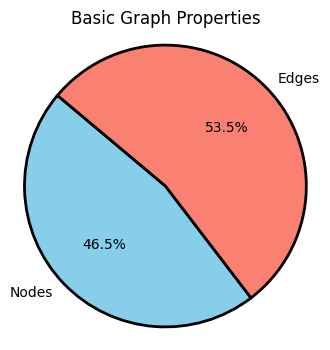

In [24]:
plt.figure(figsize=(4, 4))
sizes = [num_nodes, num_edges]
labels = ['Nodes', 'Edges']
colors = ['skyblue', 'salmon']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops = {'edgecolor' : 'black',
                      'linewidth': 2,
                      'antialiased': True})
plt.title('Basic Graph Properties')
plt.axis('equal')
plt.show()

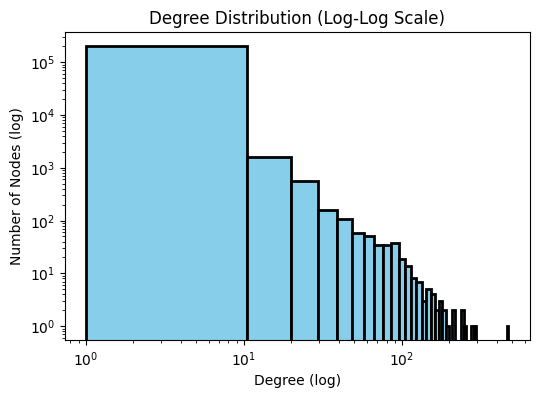

In [30]:
# --- Degree Distribution (Log-Log Scale) ---
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

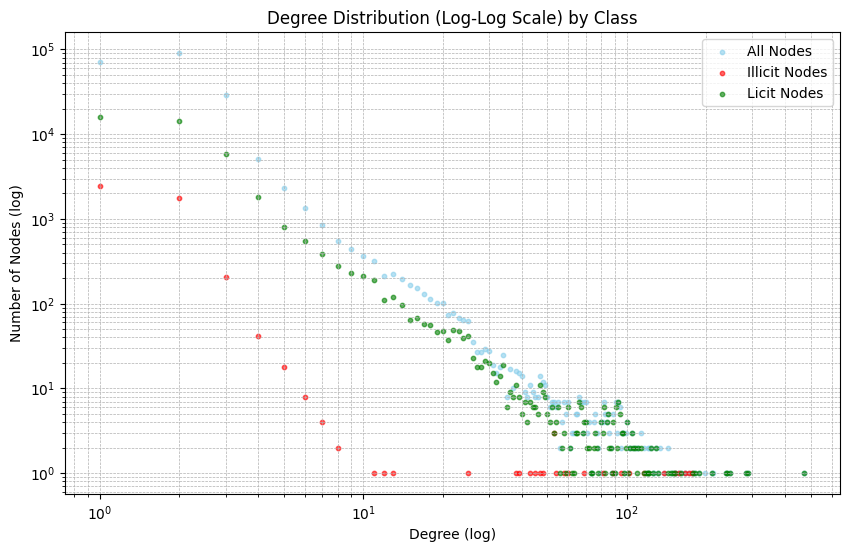

In [31]:
# Calculate degrees for all nodes in the original graph G
degrees_all = np.array([G.degree(n) for n in G.nodes()])

# Get txIds for illicit and licit transactions
illicit_txIds = elliptic_txs_classes[elliptic_txs_classes['class_mapped'] == 'illicit']['txId']
licit_txIds = elliptic_txs_classes[elliptic_txs_classes['class_mapped'] == 'licit']['txId']

# Calculate degrees for illicit and licit transactions
degrees_illicit = np.array([G.degree(n) for n in illicit_txIds if n in G])
degrees_licit = np.array([G.degree(n) for n in licit_txIds if n in G])

# Calculate degree counts for all nodes
degree_counts_all = np.bincount(degrees_all)
degrees_values_all = np.arange(len(degree_counts_all))

# Calculate degree counts for illicit nodes
degree_counts_illicit = np.bincount(degrees_illicit)
degrees_values_illicit = np.arange(len(degree_counts_illicit))

# Calculate degree counts for licit nodes
degree_counts_licit = np.bincount(degrees_licit)
degrees_values_licit = np.arange(len(degree_counts_licit))


plt.figure(figsize=(10, 6))

# Plot degree distribution for all nodes
plt.scatter(degrees_values_all, degree_counts_all, color='skyblue', label='All Nodes', s=10, alpha=0.6)

# Plot degree distribution for illicit nodes
plt.scatter(degrees_values_illicit, degree_counts_illicit, color='red', label='Illicit Nodes', s=10, alpha=0.6)

# Plot degree distribution for licit nodes
plt.scatter(degrees_values_licit, degree_counts_licit, color='green', label='Licit Nodes', s=10, alpha=0.6)


plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale) by Class')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()